In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from keras.models import Sequential
from keras.layers import LSTM,Dense ,Dropout, Bidirectional
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
import pickle

In [ ]:
#Connecting the drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data = pd.read_csv("/content/drive/MyDrive/CleanedFinalDateset/Airportfinaldata.csv")
data.head()

,Date,Precipitation,Air Temperature,Relative Humidity,Wind Speed
0,2019-11-11 06:00,0.0,23.4,69.4,2.4
1,2019-11-11 07:00,0.0,24.3,64.7,2.5
2,2019-11-11 08:00,0.0,25.0,59.3,2.5
3,2019-11-11 09:00,0.0,25.4,57.5,2.4
4,2019-11-11 10:00,0.0,24.8,60.4,2.3


In [ ]:
#checking Null Data
data.isnull().sum()

Date                 0
Precipitation        0
Air Temperature      0
Relative Humidity    0
Wind Speed           0
dtype: int64

In [ ]:
data.describe()

,Precipitation,Air Temperature,Relative Humidity,Wind Speed
count,30051.000000,30051.000000,30051.000000,30051.000000
mean,0.488752,19.713673,83.803287,1.460531
std,2.861612,6.376164,19.684580,0.742332
min,0.000000,3.500000,30.000000,0.000000
25%,0.000000,14.600000,69.900000,0.900000
50%,0.000000,20.800000,93.700000,1.400000
75%,0.000000,24.200000,100.000000,1.900000
max,45.000000,37.200000,100.000000,8.000000


# Correlation between variables

<ipython-input-8-2e5a77e2777b>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = data.corr()


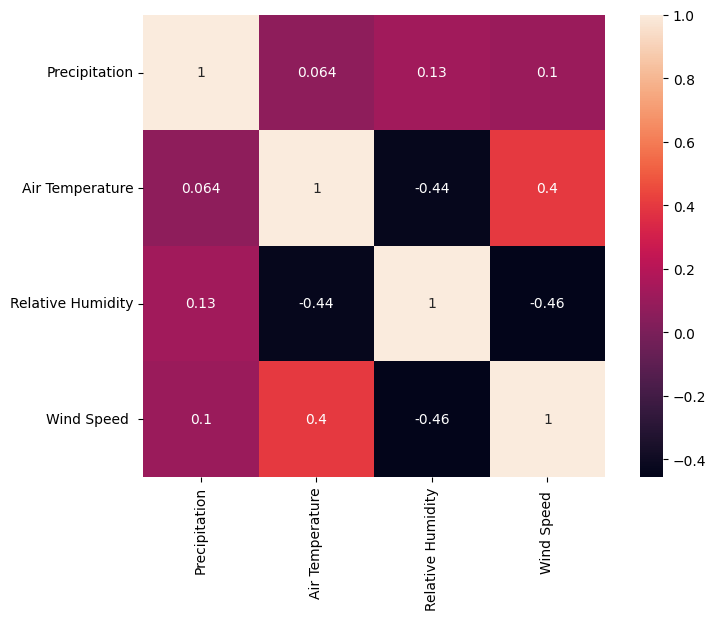

In [ ]:
# heat map of correlation of features
correlation_matrix = data.corr()
fig = plt.figure(figsize=(9,6))
sns.heatmap(correlation_matrix,vmax=1,square = True, annot= True)
plt.show()

# Extracting only data and exclusing the date

In [ ]:
#this can be used to implement dates to  plot the trend in future 
train_dates=pd.to_datetime(data['Date'])
cols = list(data)[1:5]
data_for_training= data[cols].astype(float)
data_for_training[20:30]

,Precipitation,Air Temperature,Relative Humidity,Wind Speed
20,0.0,15.9,100.0,0.9
21,0.0,17.1,100.0,1.0
22,0.0,18.9,98.2,1.1
23,0.0,21.5,79.9,1.7
24,0.0,23.3,64.7,2.1
25,0.0,24.2,62.0,2.6
26,0.0,24.9,56.8,2.4
27,0.0,25.0,55.1,2.3
28,0.0,24.8,55.5,2.4
29,0.0,24.1,61.0,1.8


# Normalizing the dataset 

In [ ]:
scaler=StandardScaler()
scaler.fit(data_for_training)
data_scaled=scaler.transform(data_for_training)

In [ ]:
#scaled dataset
data_scaled[20:30]

array([[-0.17079907, -0.59812396,  0.82282588, -0.75510739],
       [-0.17079907, -0.4099199 ,  0.82282588, -0.62039447],
       [-0.17079907, -0.12761382,  0.73138222, -0.48568154],
       [-0.17079907,  0.28016165, -0.19829492,  0.32259601],
       [-0.17079907,  0.56246774, -0.97048578,  0.86144771],
       [-0.17079907,  0.70362078, -1.10765126,  1.53501234],
       [-0.17079907,  0.81340648, -1.37182181,  1.26558649],
       [-0.17079907,  0.82909015, -1.45818526,  1.13087357],
       [-0.17079907,  0.79772281, -1.43786445,  1.26558649],
       [-0.17079907,  0.68793711, -1.15845329,  0.45730894]])

# Data preparation for Windowing

In [ ]:
# multi-step data preparation
from numpy import array
def split_sequence(data_scaled, n_past, n_future):
  X, y = list(), list()
  for i in range(len(data_scaled)):
# find the end of this pattern
    end_ix = i + n_past
    out_end_ix = end_ix + n_future
# check if we are beyond the sequence
    if out_end_ix > len(data_scaled):
      break
# gather input and output parts of the pattern
    seq_x, seq_y = data_scaled[i:end_ix,0:4], data_scaled[end_ix:out_end_ix,1]
    X.append(seq_x)
    y.append(seq_y)
  return array(X), array(y)
# choose a number of time steps
n_past, n_future = 24, 2
# split into samples
X, y = split_sequence(data_scaled, n_past, n_future)


In [ ]:
X,y=np.array(X), np.array(y)
#DATA
X.shape, y.shape

((30026, 24, 4), (30026, 2))

In [ ]:
X[:2]

array([[[-0.17079907,  0.57815141, -0.73171624,  1.26558649],
        [-0.17079907,  0.71930445, -0.97048578,  1.40029942],
        [-0.17079907,  0.82909015, -1.24481674,  1.40029942],
        [-0.17079907,  0.89182484, -1.33626039,  1.26558649],
        [-0.17079907,  0.79772281, -1.18893451,  1.13087357],
        [-0.17079907,  0.56246774, -0.78251827,  0.32259601],
        [-0.17079907,  0.37426368, -0.1627335 , -0.35096861],
        [-0.17079907,  0.31152899, -0.16781371, -0.48568154],
        [-0.17079907,  0.21742696,  0.05571523, -0.88982032],
        [-0.17079907,  0.04490657,  0.56373552, -1.15924617],
        [-0.17079907, -0.06487913,  0.82282588, -0.35096861],
        [-0.17079907, -0.11193014,  0.82282588, -0.48568154],
        [-0.17079907, -0.22171585,  0.82282588, -0.62039447],
        [-0.17079907, -0.31581787,  0.82282588, -0.75510739],
        [-0.17079907, -0.36286889,  0.82282588, -1.29395909],
        [-0.17079907, -0.3001342 ,  0.82282588, -1.15924617],
        

In [ ]:
y[1]

array([0.70362078, 0.81340648])

In [ ]:
#printing the shape:
print("The Training data i.e X shape: {}." .format(X.shape))
print("The result data  i.w y shape: {}." .format(y.shape))

The Training data i.e X shape: (30026, 24, 4).
The result data  i.w y shape: (30026, 2).


# Splitting the data into training validation and Testing


In [ ]:
# Split the data into training, validation, and test sets
num_samples = X.shape[0]
training_samples = int(np.round(num_samples * 0.8))
validation_samples = int(np.round(num_samples * 0.1))
test_samples = num_samples - training_samples - validation_samples

X_train = X[:training_samples,:]
y_train = y[:training_samples]

X_val = X[training_samples:training_samples+validation_samples,:]
y_val = y[training_samples:training_samples+validation_samples]

X_test = X[training_samples+validation_samples:,:]
y_test = y[training_samples+validation_samples:]

In [ ]:
#shapes of training, validation and test dataset:
X_train.shape,y_train.shape,X_val.shape, y_val.shape, X_test.shape, y_test.shape

((24021, 24, 4),
 (24021, 2),
 (3003, 24, 4),
 (3003, 2),
 (3002, 24, 4),
 (3002, 2))

# Bidirectional LSTM

In [ ]:
#Modeling 
model1 = Sequential()
model1.add(Bidirectional(LSTM(64, activation='relu', return_sequences=True ), input_shape=(X_train.shape[1],X_train.shape[2])))
model1.add(Bidirectional(LSTM(64, activation='relu', return_sequences=True)))
model1.add(Bidirectional(LSTM(64,activation='relu',return_sequences=True)))
model1.add(Bidirectional(LSTM(64,activation='relu')))
model1.add(Dense(y_train.shape[1], activation='linear'))

In [ ]:
#check Points of model for the saving the model
cp1= ModelCheckpoint('model1/HourlyTemperaturemodel.h5', best_model_only=True)

In [ ]:
#as the accuracy of the model is RMSE so, 
import tensorflow.keras.backend as K
def rmse(y_train, y_val):
    return K.sqrt(K.mean(K.square(y_train - y_val)))

In [ ]:
#Compile the Model
model1.compile(optimizer=Adam(learning_rate=0.001), loss=rmse, metrics='accuracy')

In [ ]:
history=model1.fit(X_train,y_train, epochs=20, validation_data=(X_val,y_val), batch_size=64, callbacks=[cp1])

Epoch 1/20
376/376 [==============================] - 117s 276ms/step - loss: 0.2900 - accuracy: 0.7650 - val_loss: 0.1912 - val_accuracy: 0.8042
Epoch 2/20
376/376 [==============================] - 104s 276ms/step - loss: 0.1757 - accuracy: 0.8234 - val_loss: 0.1499 - val_accuracy: 0.8248
Epoch 3/20
376/376 [==============================] - 140s 372ms/step - loss: 0.1578 - accuracy: 0.8353 - val_loss: 0.1410 - val_accuracy: 0.8465
Epoch 4/20
376/376 [==============================] - 127s 339ms/step - loss: 0.1477 - accuracy: 0.8422 - val_loss: 0.1433 - val_accuracy: 0.8468
Epoch 5/20
376/376 [==============================] - 103s 274ms/step - loss: 0.1436 - accuracy: 0.8464 - val_loss: 0.1464 - val_accuracy: 0.8245
Epoch 6/20
376/376 [==============================] - 103s 274ms/step - loss: 0.1382 - accuracy: 0.8473 - val_loss: 0.1364 - val_accuracy: 0.8438
Epoch 7/20
376/376 [==============================] - 99s 263ms/step - loss: 0.1370 - accuracy: 0.8492 - val_loss: 0.1303 - 

# Testing the training and validation Accuracy

In [ ]:
#Testing the training accuracy
#train_predictions=model1.predict(X_train).flatten()
#changing to the 1d to compare the result
#y_train1d=y_train.flatten()
#train_results=pd.DataFrame(data={'Train Predictions':train_predictions, 'Actuals': y_train1d})
#train_results

train_predictions=model1.predict(X_train)
train_prediction_avg=np.mean(train_predictions, axis=1)
y_train1d=np.mean(y_train, axis=1)
train_results=pd.DataFrame(data={'Test Predictions':train_prediction_avg, 'Actuals': y_train1d})
train_results

751/751 [==============================] - 30s 40ms/step


,Test Predictions,Actuals
0,0.693084,0.633044
1,0.856505,0.758514
2,0.843298,0.821248
3,0.851494,0.813406
4,0.714000,0.742830
...,...,...
24016,0.530074,0.531100
24017,0.618920,0.515417
24018,0.685637,0.515417
24019,0.743554,0.593835


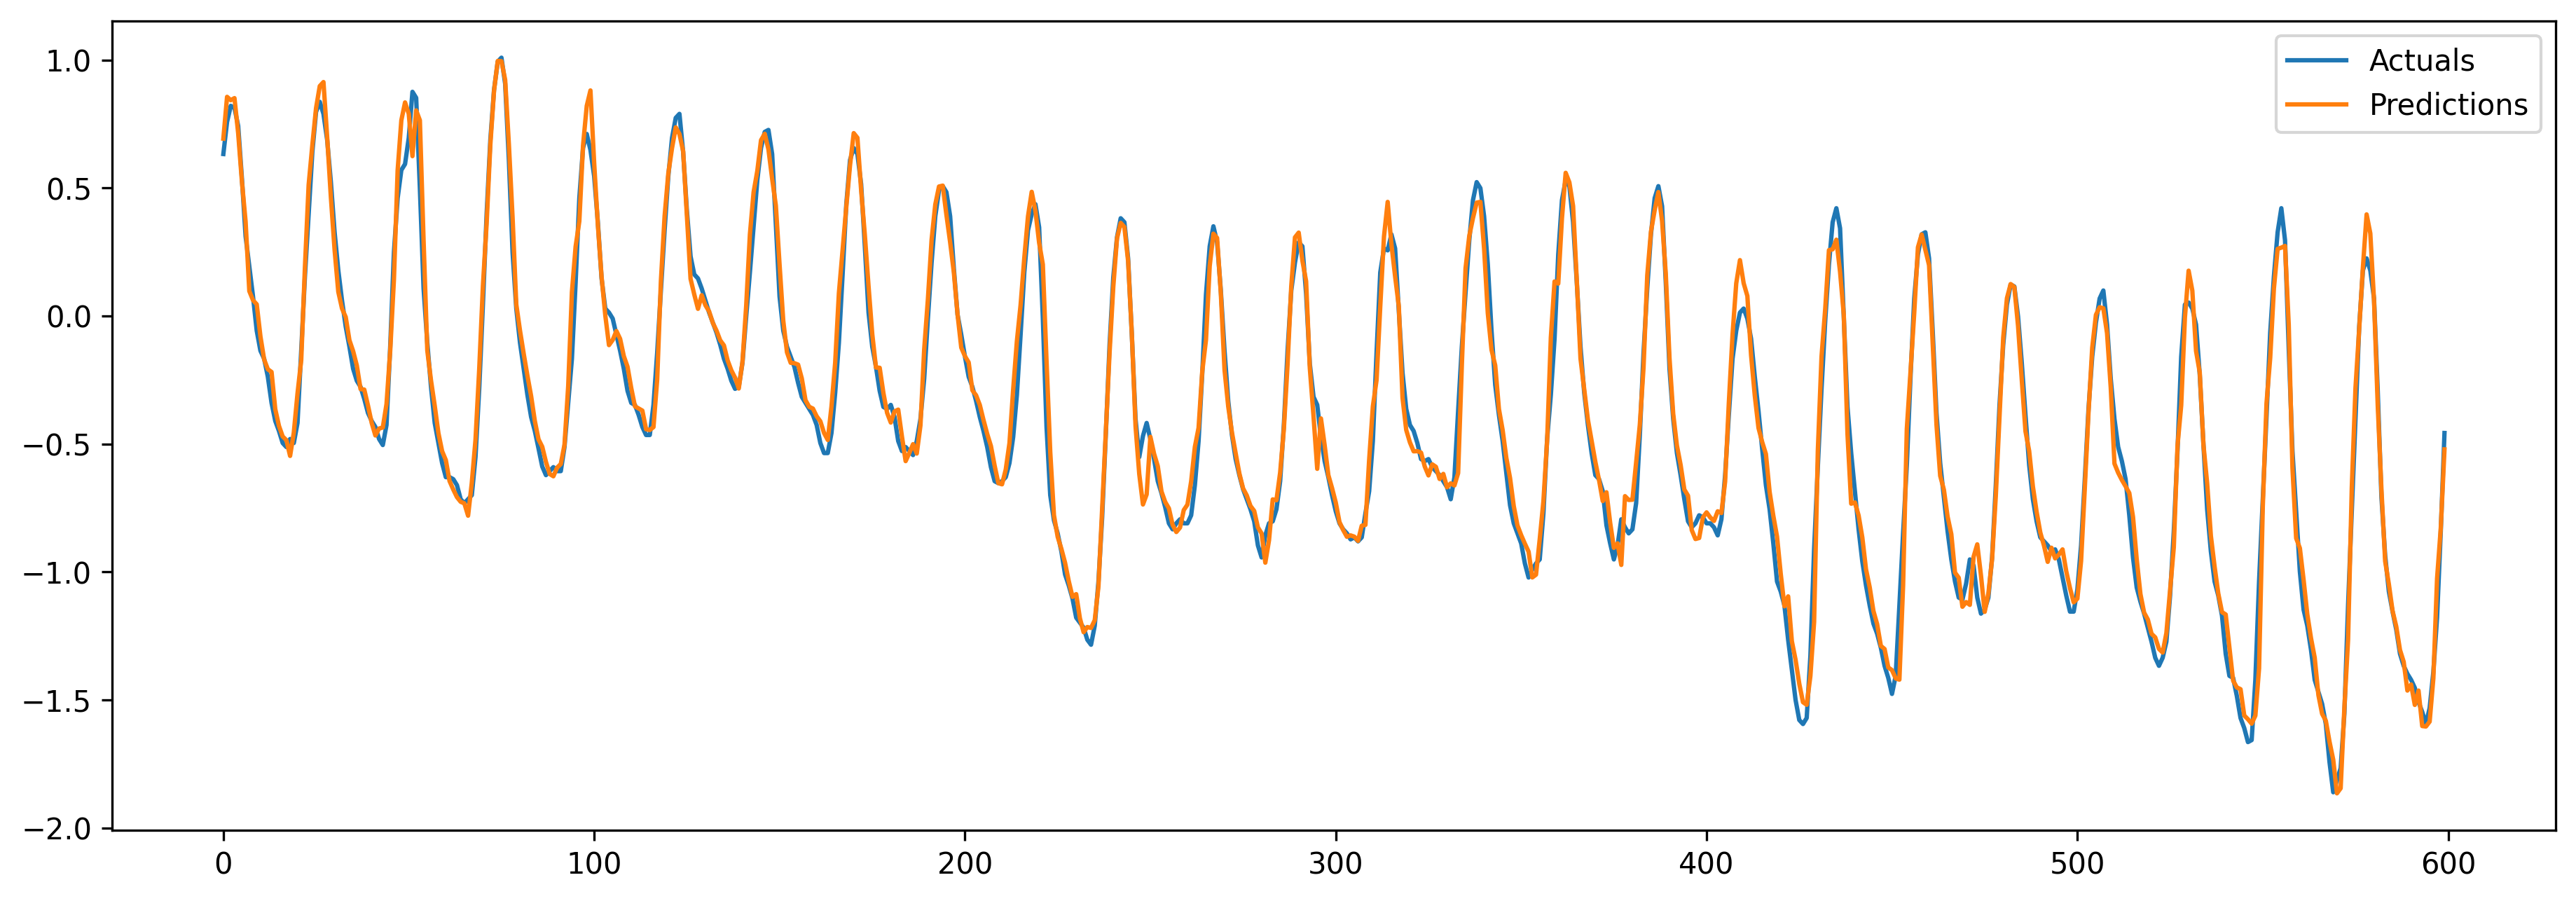

In [ ]:
#plotting the training results:
plt.figure(figsize=(15,5), dpi=300)
# Create a plot
plt.plot(y_train1d[:600], label='Actuals')
plt.plot(train_prediction_avg[0:600], label='Predictions')

# Add a legend
plt.legend()

# Show the plot
plt.show()


In [ ]:
#Testing the Test data  accuracy
#flatten will give only the 2d into 1d  so it shifts the data to some extent of right hence to not shifting this data we calculate the 
#mean so that this will give the better visualization
#test_predictions=model1.predict(X_test).flatten()
test_predictions=model1.predict(X_test)
test_prediction_avg=np.mean(test_predictions, axis=1)
y_test1d=np.mean(y_test, axis=1)
test_results=pd.DataFrame(data={'Test Predictions':test_prediction_avg, 'Actuals': y_test1d})
test_results

94/94 [==============================] - 7s 73ms/step


,Test Predictions,Actuals
0,-0.728654,-0.480496
1,-0.290287,-0.064879
2,0.122968,0.131167
3,0.191065,0.186060
4,0.067653,0.084116
...,...,...
2997,0.184099,0.433077
2998,0.614751,0.864378
2999,1.014051,1.252549
3000,1.400558,1.558381


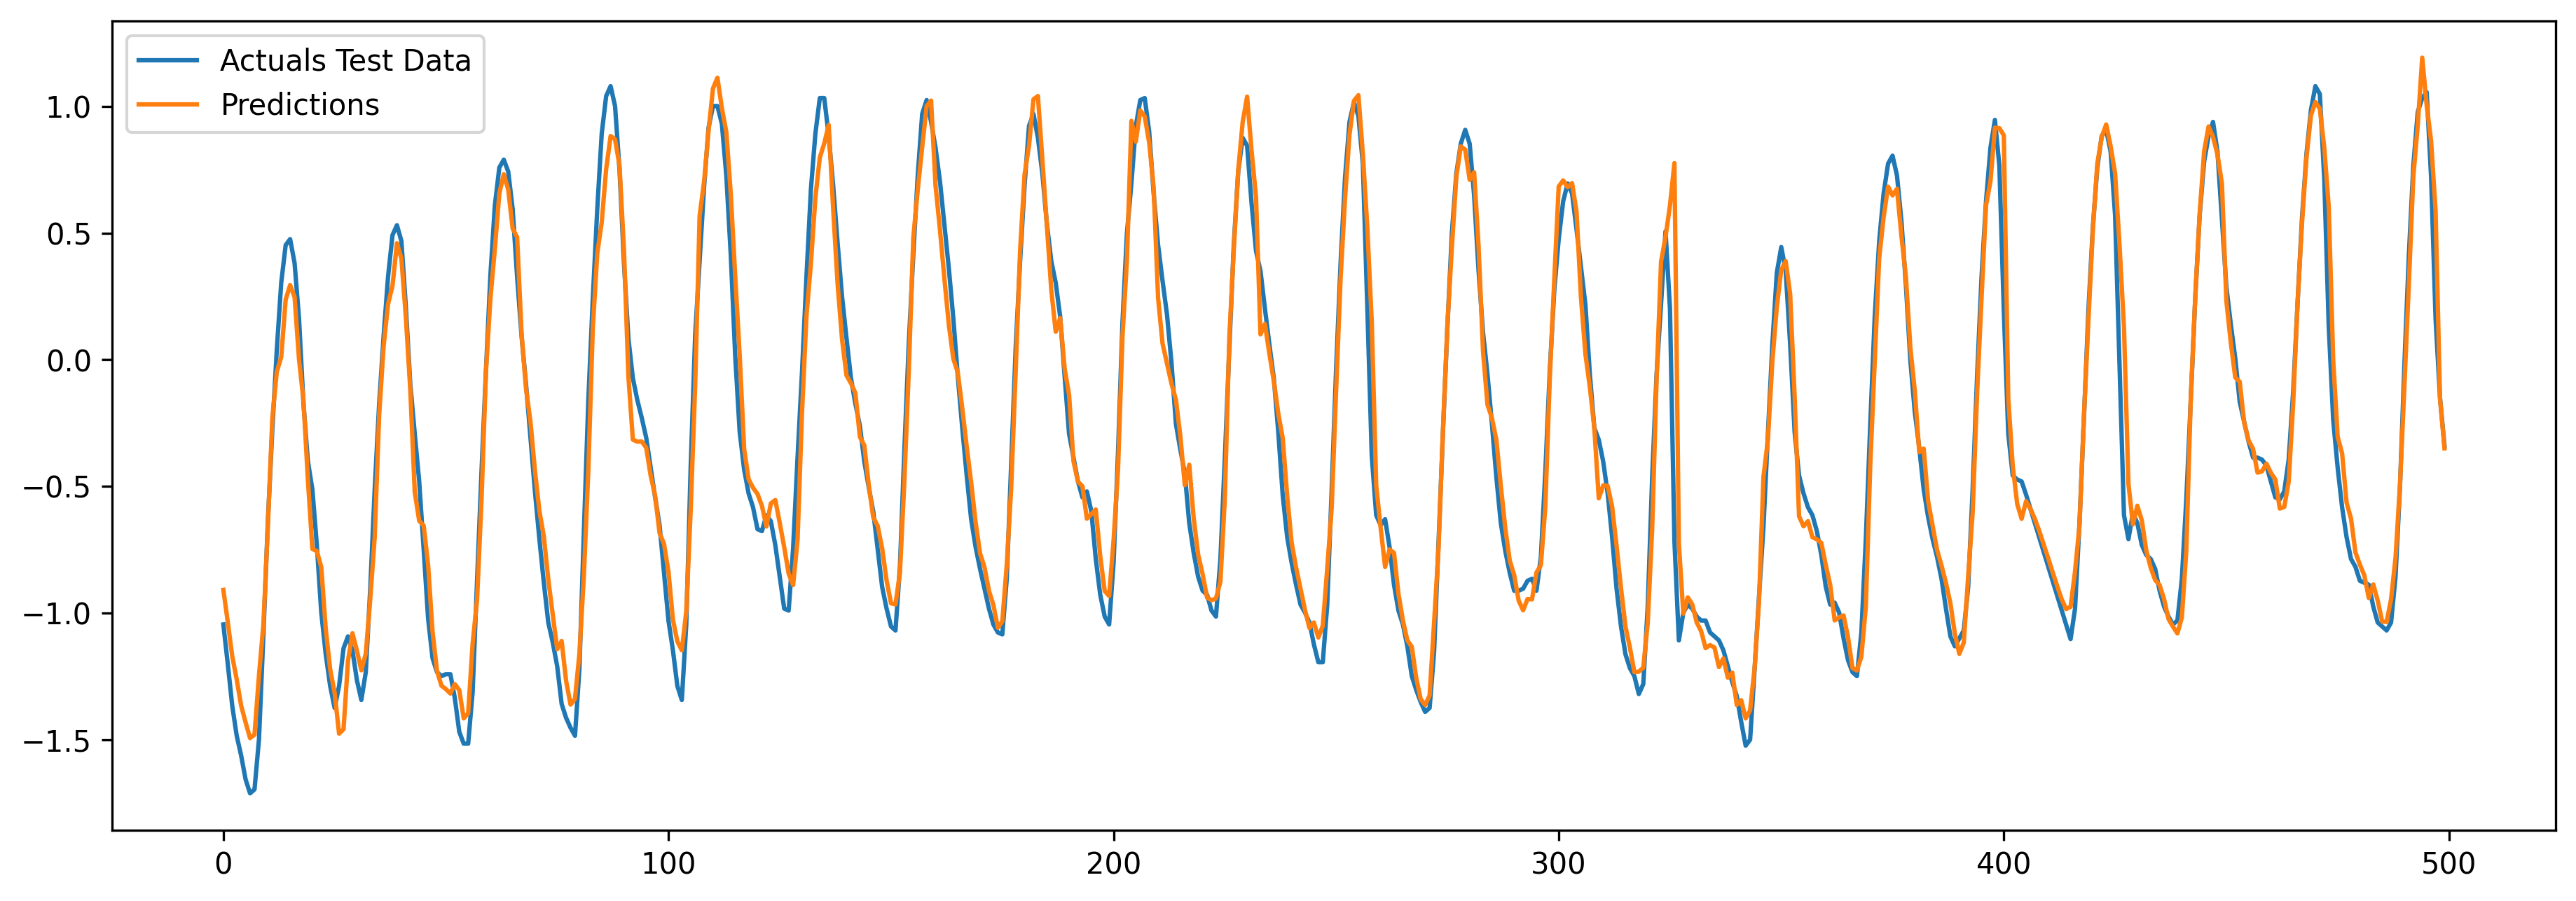

In [ ]:
#plotting the testing results:
plt.figure(figsize=(15,5), dpi=300)
# Create a plot
plt.plot(y_test1d[1500:2000], label='Actuals Test Data')
plt.plot(test_prediction_avg[1500:2000], label='Predictions')

# Add a legend
plt.legend()

# Show the plot
plt.show()

In [ ]:
# save the model and scaler to a file
with open('/content/model1/Airporthourlytemperature.pkl', 'wb') as f:
    pickle.dump((model1, scaler), f)

# Training and validation loss over epoches


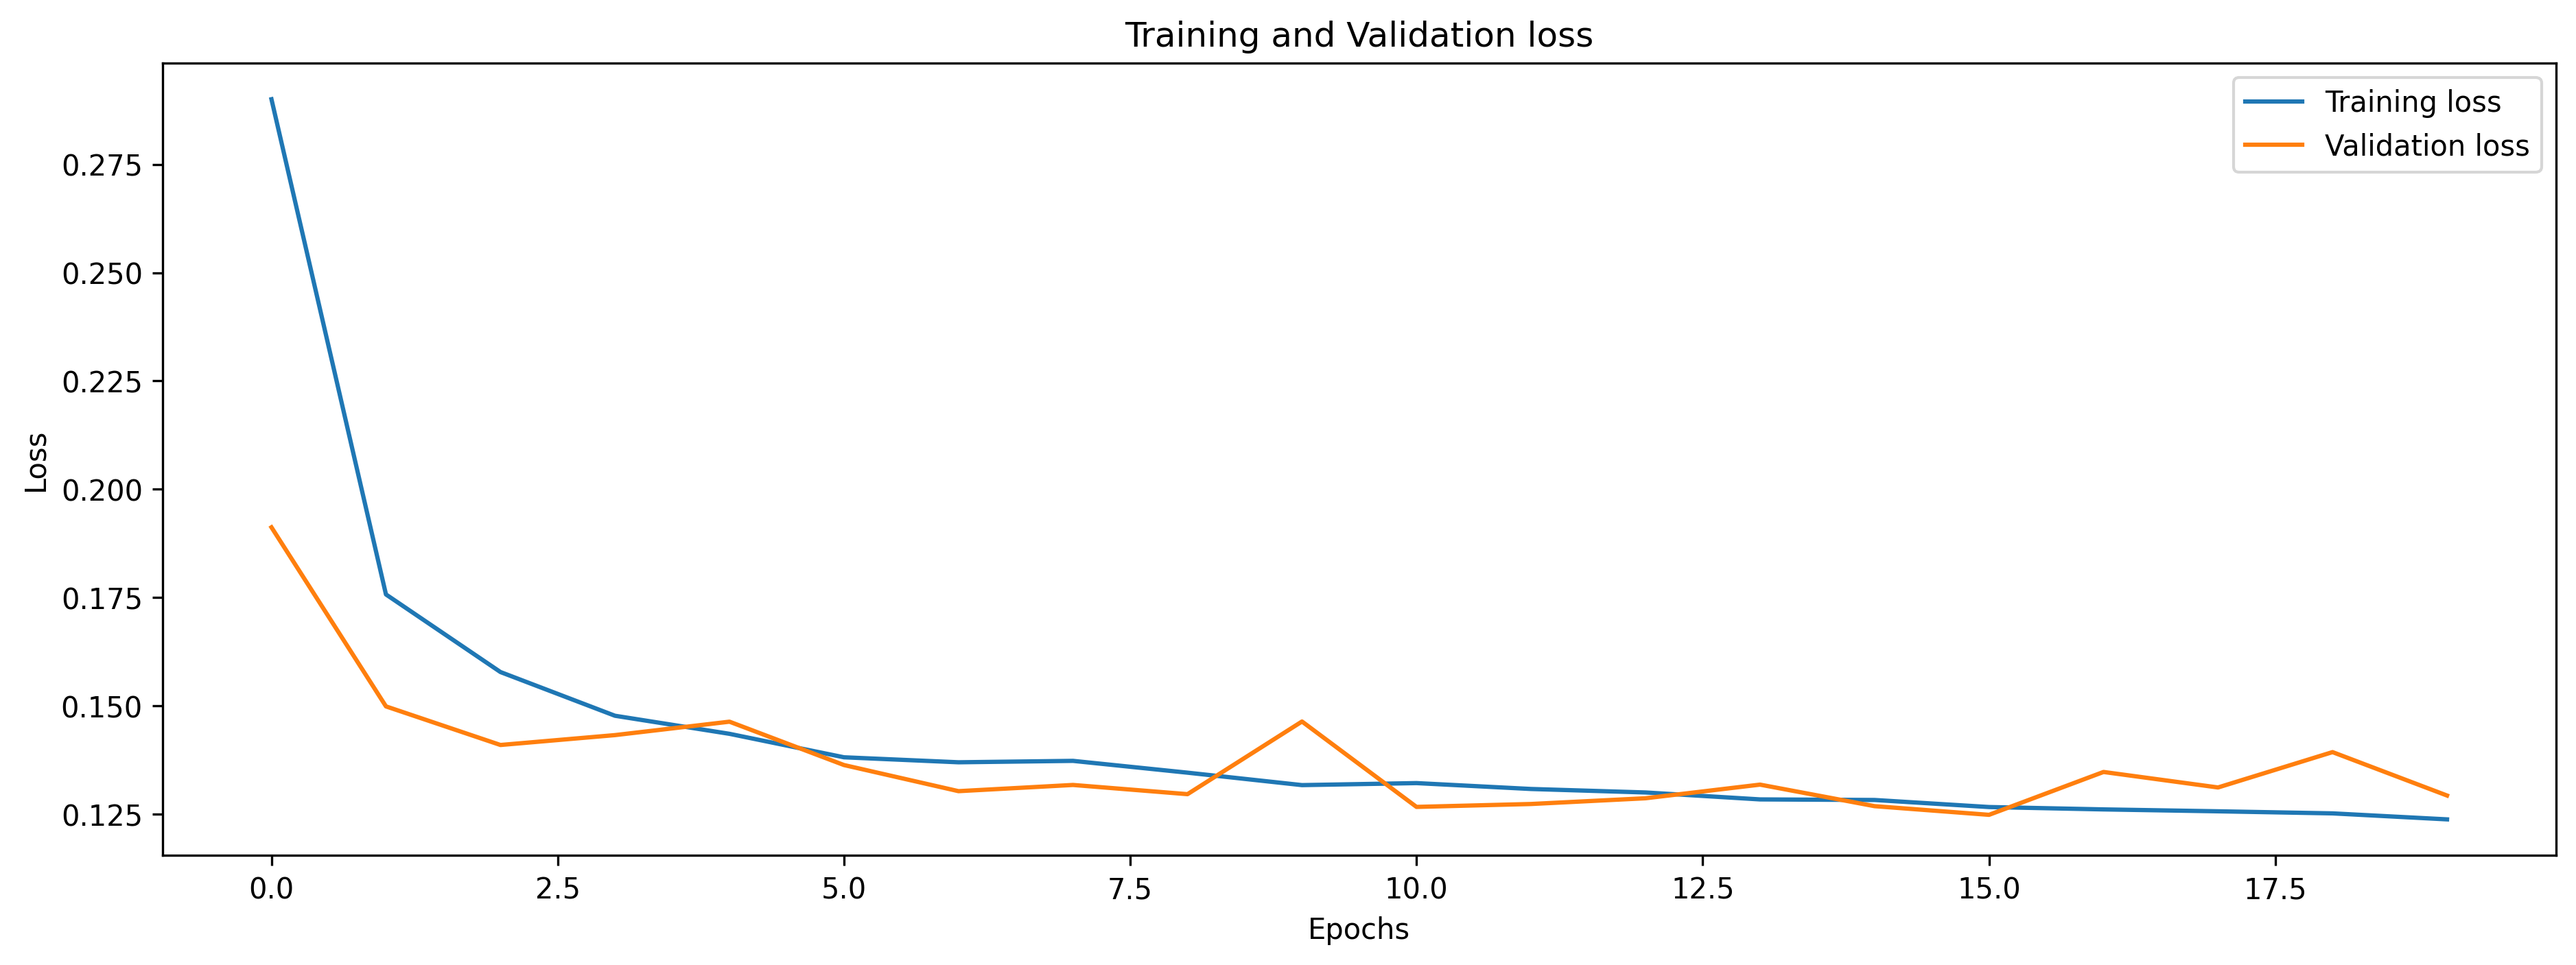

In [ ]:
#to plot the loss over the training and validation epoch we can do now as 
history_df = pd.DataFrame(history.history)
plt.figure(figsize=(15,5), dpi=300)
plt.plot(history_df.loc[:, ['loss']], label='Training loss')
plt.plot(history_df.loc[:, ['val_loss']], label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc="best")

plt.show()

# Trend in future with date.

In [ ]:
#n_future gives the number of future predictions
n_future=150
forecast_periods=pd.date_range(list(train_dates)[-1], periods=n_future, freq='1H').tolist()

In [ ]:
#forecasting the future data and it will give mentioned future prediction data and for plotting the graph 
forecast= model1.predict(X[-n_future:])
#forecast_single= forecast[:, 0].reshape((-1, 1))
forecast_avg = np.mean(forecast, axis=1)
#forecast_avg[:10]
forecast_avg_reshaped = forecast_avg.reshape(-1,1)
#forecast_avg_reshaped[:20]
#scrab only one data:

5/5 [==============================] - 0s 31ms/step


In [ ]:
#direclty it will give the error so align with the date because of different dimension difficult or throws the error while
#denormalize the data hence we now make the same dimension as of X_train and take only one column of denormalize data
forecast_copies= np.repeat(forecast_avg_reshaped, data_for_training.shape[1], axis=-1)
#now change it into the normalize data, here 1 is selct because our column is 2nd which is temperature
n_future_predictions = scaler.inverse_transform(forecast_copies)[:,1] 
n_future_predictions.shape


(150,)

In [ ]:
# now plotting in the graph
#convevrting time stamp to dates
forecast_dates=[]
for time_i in forecast_periods:
    forecast_dates.append(time_i.date())
   

In [ ]:
df_forecast= pd.DataFrame({'Date': np.array(forecast_dates), 'Air Temperature': n_future_predictions})
df_forecast['Date']=pd.to_datetime(df_forecast['Date'])
df_forecast['Date']= df_forecast["Date"].dt.strftime('%Y-%m-%d %H:%M')


In [ ]:
Original= data[['Date', 'Air Temperature']]
Original['Date']=pd.to_datetime(Original['Date'])
Original['Date']= Original["Date"].dt.strftime('%Y-%m-%d %H:%M')
Original=Original.loc[Original['Date']>'2023-04-16 0:00']

<ipython-input-160-32ce45607733>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Original['Date']=pd.to_datetime(Original['Date'])
<ipython-input-160-32ce45607733>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Original['Date']= Original["Date"].dt.strftime('%Y-%m-%d %H:%M')


<Axes: >

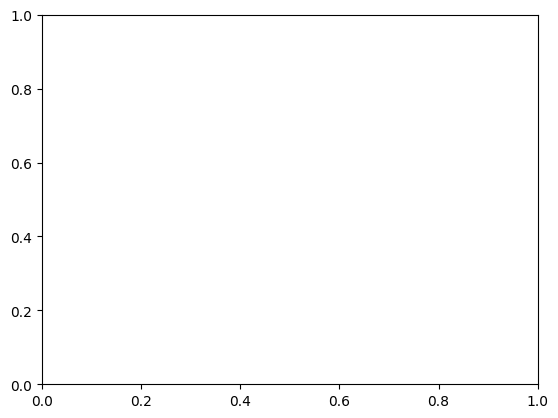

In [ ]:
#now plotting 
sns.lineplot(x='Date', y='Air Temperature', data=Original)
#sns.lineplot(x='Date',y= 'Air Temperature', data=df_forecast)